<a href="https://colab.research.google.com/github/neuralnetworksrs/Tarea-1/blob/master/Tarea_1_Parte_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 1 - Redes Neuronales y *Deep Learning* </H3>
<hr style="height:2px;border:none"/>

**Temas**  

* Entrenamiento de redes *Feed-Forward* vı́a GD y variantes (SGD, mini-*batches*), *momentum*, regularización y tasa de aprendizaje adaptiva.
* Rol de capas ocultas y mayor profundidad (*Deep Learning*).
* Diseño y entrenamiento de Redes Neuronales Convolucionales (CNNs).
* Aplicaciones de las Redes Neuronales Convolucionales
* Técnicas de regularización: *Dropout* y *Batch Normalization* 

<hr style="height:2px;border:none"/>
La tarea se divide en secciones:

1. Red Neuronal *Feed Forward* para Detectar Exoplanetas  
2. *Deep Networks*  
3. Redes Convolucionales en Imágenes  
4. CNN *vs* RNN Prediciendo el Ozono Atmosférico

## 3. Redes Convolucionales en Imágenes
---

En esta sección trabajaremos con un *dataset* bastante conocido y utilizado por la comunidad para experimentar reconocimiento de objetos en imágenes: CIFAR-10. Se trata de un conjunto de 60000 imágenes RGB de 32 × 32 pixeles que contiene 10 clases de objetos y 6000 ejemplos por clase. La versión utilizada se le atribuye a *A. Krizhevsky, V. Nair* y *G. Hinton*  [[10]](#refs), viene separada en 50000 ejemplos de entrenamiento y 10000 casos de prueba que fueron obtenidos seleccionando 1000 imágenes aleatorias de cada clase. Cabe destacar que las clases son mutuamente excluyentes y corresponden a las siguientes categorı́as: 

<img src="https://cv-tricks.com/wp-content/uploads/2017/03/alexnet_small.png.pagespeed.ce.j1fiN1R4Hv.png" title="YOLO" width="70%"/>

* Avión
* Automóvil
* Pájaro
* Gato
* Ciervo
* Perro
* Rana
* Caballo
* Barco
* Camión


Para esta tarea se experimentará con redes convolucionales, conocidas como CNNs ó ConvNets.  
**Nota:** Para esta actividad es bastante aconsejable entrenar las redes usando una GPU, ya que de otro modo los tiempos de entrenamiento serán largos. 


**Recuerde que si encuentra cosas ventajosas en alguna pregunta, puede y debería seguir utilizandolas en las siguientes**

---

Cargue todos los datos de entrenamiento y pruebas del problema CIFAR. Además de generar un conjunto de validación del conjunto de entrenamiento y que no debe superar las 5000 imágenes.

In [0]:
from keras.callbacks import Callback
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        test_loss.append(loss)
        test_acc.append(acc)
        #print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

def plot_graphs(history):
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.plot(test_acc)
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.plot(test_loss)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val', 'test'], loc='upper left')
  plt.show()
  

In [0]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

def graph_loss_vs_epochs(hist, epoch):
  loss_b = np.array(hist.history['loss'])
  epochs_b = np.arange(epoch)

  plt.plot(epochs_b, loss_b)
  plt.title('Number of epochs vs NN error')
  plt.xlabel('epochs')
  plt.ylabel('loss (mse)')
  plt.show() 

In [0]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(label_names)
import numpy as np   
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [0]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.00012, random_state=1)

In [31]:

x_val.size

6144

**a)** Visualice los datos que trabajaremos e intentaremos detectar en esta sección. ¿Qué dimensiones tienen las imágenes trabajadas? ¿Existen patrones similares entre los objetos de una misma clase? ¿Entre objetos de distintas clases?

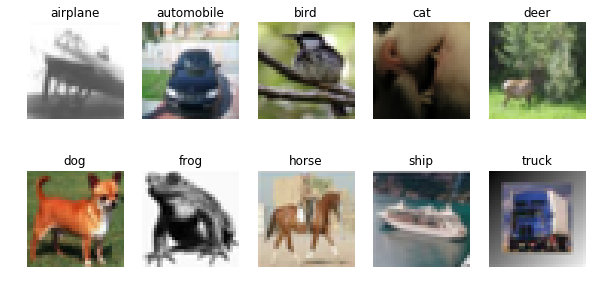

In [32]:
idx_dato = [np.random.choice(np.where(y_train==i)[0]) for i in range(10)] #sample from each class
f,axx = plt.subplots(2,5,figsize=(10,5))
for i, dato in enumerate(idx_dato):
    axx[int(i/5),i%5].imshow(x_train[dato])
    axx[int(i/5),i%5].axis('off')
    axx[int(i/5),i%5].set_title(label_names[i])
plt.show()

El patrón más notorio de todas las imagenes es que todas son un primer plano del objeto de la imagen, y ninguna de ellas tiene superposición de otros objetos. A vista del ojo y la mente humana es posible apreciar ciertas similitudes entre algunos de los objetos dentro de la clasificación como los son el perro y el gato, el caballo con el venado, los autos con los camiones, etc..

**b)** Prepare los subconjuntos de entrenamiento, validación y pruebas para ser entregados al modelo. Para ésto divida la intensidad original de pixel en cada canal por 255. Es importante notar que si desea trabajar con el orden de las dimensiones denominado ’th’ (por defecto para *Theano*) deberá realizar la transposición correspondiente para dejar el canal en donde corresponda. Finalmente, genere una representación adecuada de las salidas deseadas de la red.

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD, rmsprop
#x_train = x_train.transpose([0, 3, 1, 2]) #if 'th' dim-ordering is usedsalidas deseadas de la red.
#x_test= x_test.transpose([0, 3, 1, 2]) 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
Xnorm_train = x_train.astype('float32')/255
Xnorm_val = x_val.astype('float32')/255
Xnorm_test = x_test.astype('float32')/255

**c)** Defina una CNN simple con arquitectura $C \times P \times C \times P \times F \times F$. Para ambas capas convolucionales utilice 32 y 64 filtros de $3 \times 3$ y funciones de activación ReLU respectivamente. Para las capas de *pooling* utilice filtros de $2 \times 2$ con *stride* 2. Para la capa MLP escondida use 512 neuronas. Genere un esquema lo más compacto posible que muestre los cambios de forma (dimensionalidad) que experimenta un patrón de entrada a medida que se ejecuta un *forward-pass* y el número de parámetros de cada capa.

In [34]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=Xnorm_train.shape[1:],activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(10,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               2097664   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total para

**d)** Entrene la CNN definida en **c)** utilizando SGD. En este dataset, una tasa de aprendizaje “segura” es $\eta = 10^{-4}$ o inferior con una tasa de decaimiento, pero durante las primeras *epochs* el entrenamiento resulta demasiado lento. Para resolver el problema compare el entrenar con un optimizador adaptativo como es **RMSProp** con parámetros similares. Construya un gráfico que muestre los errores de entrenamiento, validación y pruebas como función del número de “epochs”, entrene con 25 *epochs*.

In [0]:
test_loss = []
test_acc = []
opt = SGD(lr=1e-4,decay=1e-6)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
hist_SGD = model.fit(Xnorm_train, y_train, epochs=25, verbose=0,
                     validation_data=(Xnorm_val,y_val), callbacks=[TestCallback((Xnorm_test, y_test))])

In [36]:
print(hist_SGD.history)

{'val_loss': [2.3056554794311523, 2.284193515777588, 2.267772674560547, 2.256406307220459, 2.247067451477051, 2.237163543701172, 2.229325294494629, 2.22170352935791, 2.2164759635925293, 2.2011616230010986, 2.190664291381836, 2.173144817352295, 2.1715598106384277, 2.117544651031494, 2.1194725036621094, 2.097707986831665, 2.0927419662475586, 2.057997465133667, 2.037457227706909, 2.0323119163513184, 2.0197436809539795, 2.013036012649536, 2.0064125061035156, 1.9854916334152222, 1.9545691013336182], 'val_acc': [0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0], 'loss': [2.3012294023132323, 2.292675549926758, 2.2859212731933596, 2.2793015966796877, 2.2722490225982668, 2.264457921142578, 2.2556127939605712, 2.2454085148620604, 2.233713020019531, 2.22046275390625, 2.2053682244873047, 2.1884583084106444, 2.170338586921692, 2.1515568561553957, 2.1325648916625974, 2.114004177093506, 2.0958006701660157, 2.078332388534546, 2

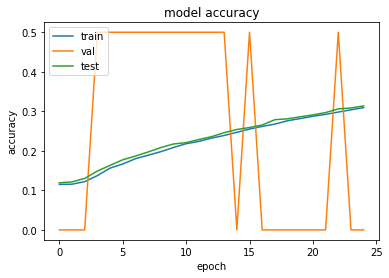

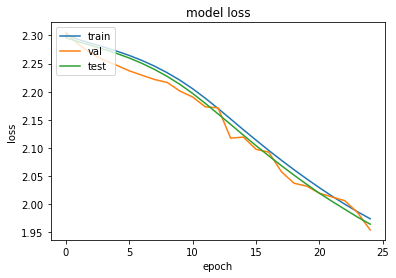

In [37]:
plot_graphs(hist_SGD)

In [0]:
test_loss = []
test_acc = []

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=Xnorm_train.shape[1:],activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(10,activation='softmax'))

opt = rmsprop(lr=1e-4, decay=1e-6)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
hist_rmsprop = model.fit(Xnorm_train, y_train, epochs=25, verbose=0,
                         validation_data=(Xnorm_val, y_val),callbacks=[TestCallback((Xnorm_test, y_test))])

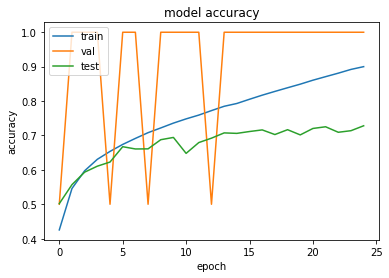

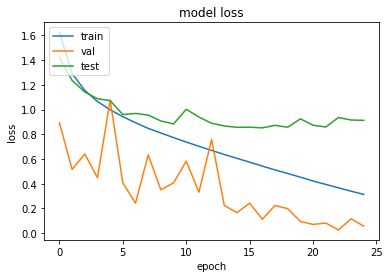

In [39]:
plot_graphs(hist_rmsprop)

**e)** Ahora bien, para mejorar los resultados encontrados deberá aumentar o reducir el número de capas, dependiendo de qué dice su intuición. Deberá elegir sobre dónde aumentar o reducir el número de capas, la fase convolucional y/o la fase *feed forward*, no olvide que al aumentar el número de capas (como en la sección 2) conlleva ciertas consecuencias, lo más importante el *overfitting*, vea cómo reducir ésto.

In [40]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=Xnorm_train.shape[1:],activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dense(10,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
__________

In [0]:
test_loss = []
test_acc = []
opt = SGD(lr=1e-4,decay=1e-6)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
hist_SGD_1 = model.fit(Xnorm_train, y_train, epochs=25, verbose=0,
                     validation_data=(Xnorm_val,y_val), callbacks=[TestCallback((Xnorm_test, y_test))])

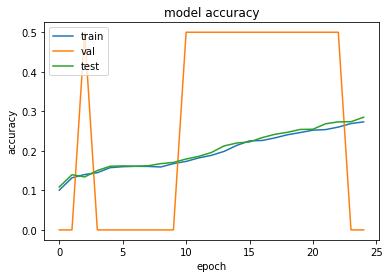

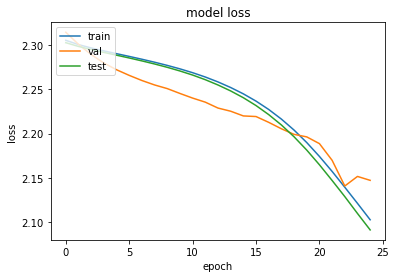

In [42]:
plot_graphs(hist_SGD_1)

In [0]:
test_loss = []
test_acc = []

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=Xnorm_train.shape[1:],activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dense(10,activation='softmax'))

opt = rmsprop(lr=1e-4, decay=1e-6)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
hist_rmsprop_1 = model.fit(Xnorm_train, y_train, epochs=25, verbose=0,
                         validation_data=(Xnorm_val, y_val),callbacks=[TestCallback((Xnorm_test, y_test))])

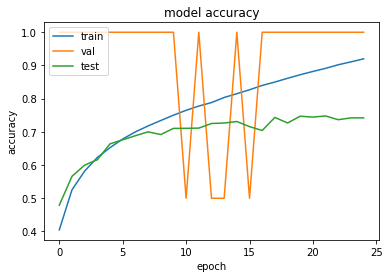

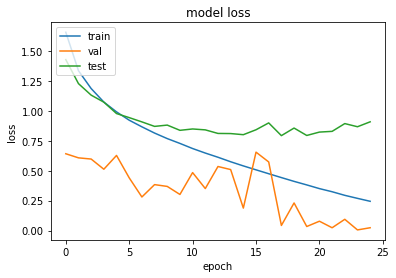

In [44]:
plot_graphs(hist_rmsprop_1)

**f)** Duplique el tamaño de los filtros utilizados en la primera capa convolucional. ¿Qué efecto tiene esto sobre el tipo de patrones que detectará la red? ¿Porqué usar filtros pequeños no impide detectar patrones más grandes?

In [45]:
model = Sequential()
model.add(Conv2D(32*2, (3, 3), padding='same', input_shape=Xnorm_train.shape[1:],activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dense(10,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
__________

In [0]:
test_loss = []
test_acc = []
opt = SGD(lr=1e-4,decay=1e-6)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
hist_SGD_2 = model.fit(Xnorm_train, y_train, epochs=25, verbose=0,
                     validation_data=(Xnorm_val,y_val), callbacks=[TestCallback((Xnorm_test, y_test))])

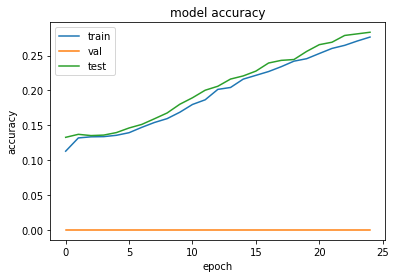

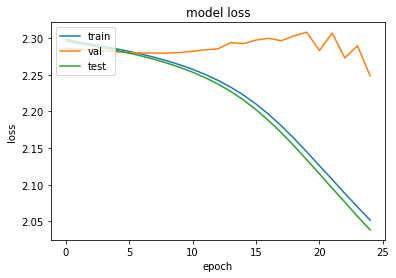

In [47]:
plot_graphs(hist_SGD_2)

In [0]:
test_loss = []
test_acc = []

model = Sequential()
model.add(Conv2D(32*2, (3, 3), padding='same', input_shape=Xnorm_train.shape[1:],activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dense(10,activation='softmax'))

opt = rmsprop(lr=1e-4, decay=1e-6)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
hist_rmsprop_2 = model.fit(Xnorm_train, y_train, epochs=25, verbose=0,
                         validation_data=(Xnorm_val, y_val),callbacks=[TestCallback((Xnorm_test, y_test))])

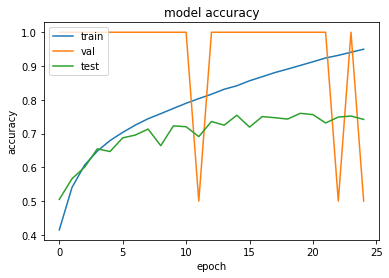

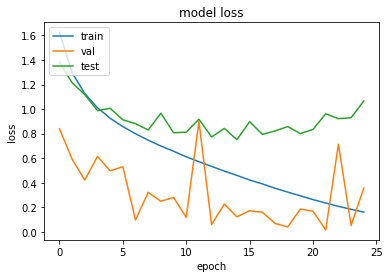

In [49]:
plot_graphs(hist_rmsprop_2)

**g)** Duplique el número de filtros utilizados en las capas convolucionales. ¿Qué efecto tiene esto sobre la capacidad de aprendizaje de la red?

In [50]:
model = Sequential()
model.add(Conv2D(32*2, (3, 3), padding='same', input_shape=Xnorm_train.shape[1:],activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64*2, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(10,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dense_16 (Dense)             (None, 10)                5130      
Total para

In [0]:
test_loss = []
test_acc = []
opt = SGD(lr=1e-4,decay=1e-6)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
hist_SGD_3 = model.fit(Xnorm_train, y_train, epochs=25, verbose=0,
                     validation_data=(Xnorm_val,y_val), callbacks=[TestCallback((Xnorm_test, y_test))])

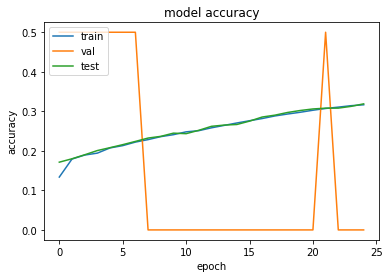

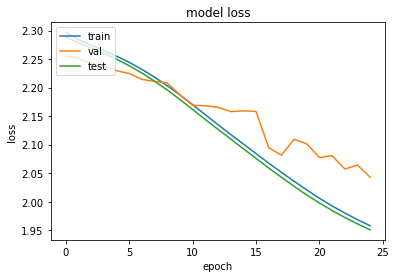

In [52]:
plot_graphs(hist_SGD_3)

In [0]:
test_loss = []
test_acc = []

model = Sequential()
model.add(Conv2D(32*2, (3, 3), padding='same', input_shape=Xnorm_train.shape[1:],activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64*2, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(10,activation='softmax'))

opt = rmsprop(lr=1e-4, decay=1e-6)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
hist_rmsprop_3 = model.fit(Xnorm_train, y_train, epochs=25, verbose=0,
                         validation_data=(Xnorm_val, y_val),callbacks=[TestCallback((Xnorm_test, y_test))])

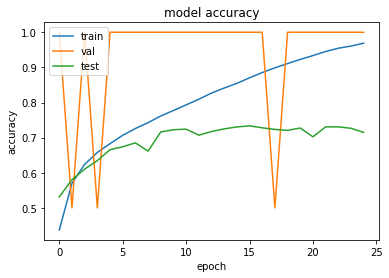

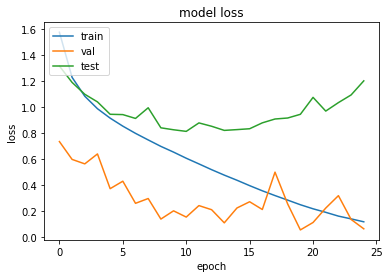

In [54]:
plot_graphs(hist_rmsprop_3)

**h)** Se ha sugerido que la práctica bastante habitual de continuar una capa convolucional con una capa de *pooling* puede generar una reducción prematura de las dimensiones del patrón de entrada. Experimente con una arquitectura del tipo $C \times P \times C \times P \times F \times F$ versus  $C \times C \times P \times C \times C \times P \times F \times F$. Use 32 filtros para la primera capa convolucional y 64 para la segunda.  Como resultado final de esta actividad, al igual que las otras, grafique los errores de entrenamiento, validación y pruebas como función del número de “epochs” (fijando el máximo en un número razonable como T = 25).
> **Hint:** con esta nueva arquitectura debiese superar el 70% de accuracy (de validación/test), pero la arquitectura es más sensible a overfitting por lo que podrı́a ser conveniente agregar un regularizador ¿Dónde? ¿Qué tan potente?

In [55]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=Xnorm_train.shape[1:], activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(10,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 32)        18464     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 4096)              0         
__________

In [0]:
test_loss = []
test_acc = []
opt = SGD(lr=1e-4,decay=1e-6)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
hist_SGD_4 = model.fit(Xnorm_train, y_train, epochs=25, verbose=0,
                     validation_data=(Xnorm_val,y_val), callbacks=[TestCallback((Xnorm_test, y_test))])

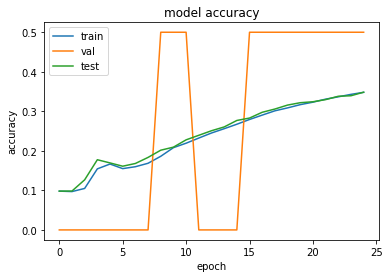

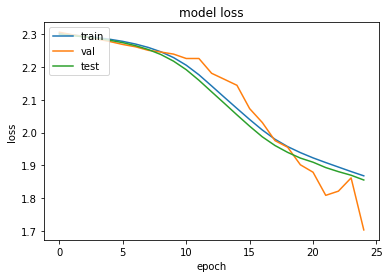

In [57]:
plot_graphs(hist_SGD_4)

In [0]:
test_loss = []
test_acc = []

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=Xnorm_train.shape[1:], activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(10,activation='softmax'))

opt = rmsprop(lr=1e-4, decay=1e-6)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
hist_rmsprop_4 = model.fit(Xnorm_train, y_train, epochs=25, verbose=0,
                         validation_data=(Xnorm_val, y_val),callbacks=[TestCallback((Xnorm_test, y_test))])

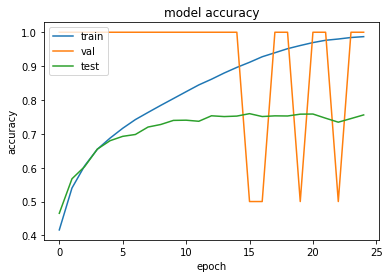

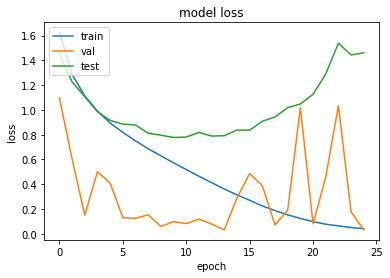

In [59]:
plot_graphs(hist_rmsprop_4)

**i)** Algunos investigadores, han propuesto que las capas de *pooling* se pueden reemplazar por capas convoluciones con *stride* 2. ¿Se reduce dimensionalidad de este modo? Compruébelo verificando los cambios de forma (dimensionalidad) que experimenta un patrón de entrada a medida que se ejecuta un *forward-pass*. Entrene la red resultante con el método que prefiera, gráficando los errores de entrenamiento, validación y pruebas como función del número de “epochs” (fijando el máximo en un número razonable como T = 25).

In [60]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=Xnorm_train.shape[1:], activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same',activation='linear'))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(10,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 16384)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               8389120   
_________________________________________________________________
dense_24 (Dense)             (None, 10)                5130      
Total params: 8,469,898
Trainable params: 8,469,898
Non-trainable params: 0
_________________________________________________________________


In [0]:
test_loss = []
test_acc = []
opt = SGD(lr=1e-4,decay=1e-6)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
hist_SGD_5 = model.fit(Xnorm_train, y_train, epochs=25, verbose=0,
                     validation_data=(Xnorm_val,y_val), callbacks=[TestCallback((Xnorm_test, y_test))])

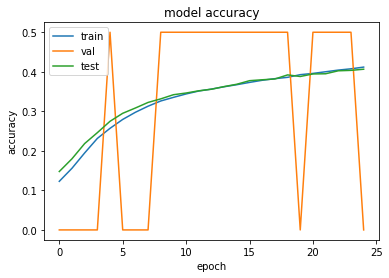

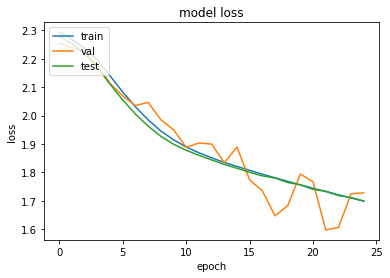

In [62]:
plot_graphs(hist_SGD_5)

In [0]:
test_loss = []
test_acc = []

model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=Xnorm_train.shape[1:], activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same',activation='linear'))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(10,activation='softmax'))

opt = rmsprop(lr=1e-4, decay=1e-6)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
hist_rmsprop_5 = model.fit(Xnorm_train, y_train, epochs=25, verbose=0,
                         validation_data=(Xnorm_val, y_val), callbacks=[TestCallback((Xnorm_test, y_test))])

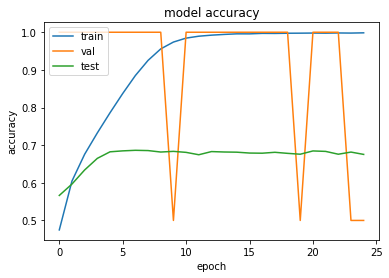

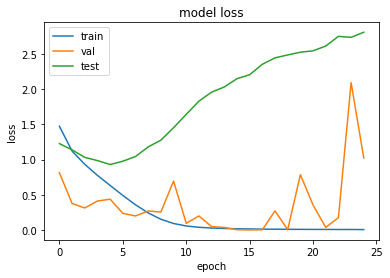

In [64]:
plot_graphs(hist_rmsprop_5)

**j)** Una forma interesante de regularizar modelos entrenados para visión artificial consiste en “aumentar” el número de ejemplos de entrenamiento usando transformaciones sencillas como: rotaciones, corrimientos y reflexiones, tanto horizontales como verticales. Explique por qué este procedimiento podrı́a ayudar a mejorar el modelo y el por qué las etiquetas no cambian al aplicar estas operaciones. Evalúe experimentalmente la conveniencia de incorporarlo.

In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=Xnorm_train.shape[1:], activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(10,activation='softmax'))

opt = SGD(lr=1e-4,decay=1e-6)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=0, # randomly rotate images (degrees, 0 to 180)
    width_shift_range=0.1, # randomly shift images horizontally (fraction of width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of height)
    horizontal_flip=True, # randomly flip images
    vertical_flip=False) # randomly flip images

test_loss = []
test_acc = []
datagen.fit(Xnorm_train)
hist_SGD_6 = model.fit_generator(datagen.flow(Xnorm_train, y_train,batch_size=50),steps_per_epoch=Xnorm_train.shape[0]// 50, epochs=25,validation_data=(Xnorm_val, y_val), verbose=0, callbacks=[TestCallback((Xnorm_test, y_test))])

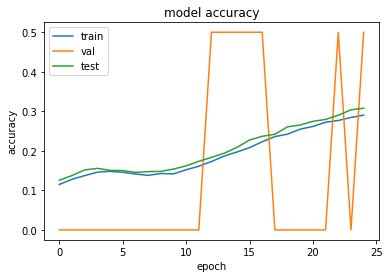

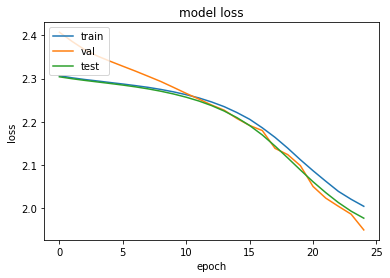

In [67]:
plot_graphs(hist_SGD_6)

**k)** Ahora se experimentará con el concepto de *transfer learning* [[11]](#refs), el cual consta en transferir conocimiento de un dominio fuente (*source domain*) a un dominio objetivo (*target domain*). En redes neuronales existen muchas representaciones de esto, en común consta en pre inicializar los pesos de la red de alguna manera que no sea con distribuciones de manera aleatoria, conocido como *fine tunning*. También está lo que es utilizar una representación generada a través de otra red entrenada con muchos datos, esto es tomar la red y "congelar" sus primeras capas para tomar esta representación y no entrenar esos pesos. Para ésto se utilizará VGG16 [[12]](#refs), una red entrenada con millones de imágenes y proporcionada a través de la interfaz de *keras*. Visualice el modelo y sus 23 capas.  Para esta instancia se utilizará todo lo aprendido por las capas convolucionales, es decir, se eliminan las capas densas del modelo y se agregan unas nuevas a ser entrenadas desde cero.  
*Recuerde normalizar los datos de la manera en que fue entrenado VGG* ¿Cuál es éste proceso?

In [68]:
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

X_train_vgg = preprocess_input(x_train.astype('float32'))
X_test_vgg = preprocess_input(x_test.astype('float32'))
X_val_vgg = preprocess_input(x_val.astype('float32'))

modelVGG = VGG16(weights='imagenet', include_top=False) # LOAD PRETRAINED MODEL

features_train = modelVGG.predict(X_train_vgg)
features_test = modelVGG.predict(X_test_vgg)
features_test = modelVGG.predict(X_val_vgg)

modelVGG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

**l)** Entrene esta red agregando una capa densa de 512 neuronas seguido de un dropout de 0.5, finalmente es necesario agregar la capa de clasificación para las 10 clases. Utilice la misma configuración del optimizador para que las comparaciones sean válidas. Entrene unicamente por 15 *epochs* y grafique las curvas de entrenamiento con respecto al modelo definido en c) y la mejor encontrada ¿Qué sucede? Comente.

In [69]:
modelVGG.add(Flatten(input_shape=features_train.shape[1:]))
modelVGG.add(Dense(512, activation='relu'))

test_loss = []
test_acc = []

modelVGG.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
hist_VGG = modelVGG.fit(features_train, y_train,epochs=15, batch_size=128,verbose=1,validation_data=(features_val,y_val), callbacks=[TestCallback((features_test, y_test))])

AttributeError: ignored

**m)** Agregue una capa de normalización (*Batch Normalization* [[9]](#refs)) de las activaciones en las capas densas, esto es, restar por la media del *mini-batch* y dividir por la desviación estándar en conjunto con unos parámetros aprendibles, además de agregar *Dropout*[[8]](#refs). Vuelva a entrenar el modelo con la misma configuración. Comente lo observado y compare las curvas de convergencia con los modelos anteriores ¿Por qué esto mejora a lo presentado en **l)**? ¿Qué beneficio tiene resolver un problema con una red pre-entrenada?

In [0]:
model = Sequential()
model.add(Flatten(input_shape=features_train.shape[1:]))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(value))

#clasification
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(features_train, y_train,epochs=epochs_, batch_size=128,verbose=1,validation_data=(features_test,y_test))

**n)** Genere $T$ nuevas etiquetas para el dataset de CIFAR en base a las etiquetas de éstas, pero que sean "paralelas", es decir, un objeto/imagen puede tener una etiqueta de las posibles en CIFAR y una de las nuevas que usted genere, ésto se denomina **Multi-task**[[13]](#refs). Por ejemplo una nueva *task* podría ser identificar/distinguir entre animales u objetos (de manera binaria, 0 y 1) en los datos de CIFAR, ésto debe ser unicamente extraído a través de las etiquetas de CIFAR. Defina la sección compartida de la red, que se compartirá para aprender las $T+1$ tareas, que tome como entrada las imágenes de CIFAR, ya sean los pixeles o la representación de *VGG* y genere como salida una representación intermedia (*hidden*) que servirá después para aprender la probabilidad (*softmax* o *sigmoid*) de cada *task*.

In [0]:
# create your new tasks
shared_model = Sequential()
...
shared_model.add(Dense(n_hidd,activation='relu'))
shared_model.summary() 

**o)** Defina y entrene el modelo multi-task que prediga las $T$ nuevas *task* que definió en la pregunta anterior más la clasificación sobre CIFAR, *task 1*. Grafique las $T+1$ funciones objetivos que se optimizan en paralelo, comente. Verifique si el uso de las nuevas $T$ *task* auxiliares ayudan a regularizar a la red sobre la tarea principal, la clasificación sobre las etiquetas de CIFAR (*task 1*).   
*Como ayuda se entrega que como la task1 es la clasificación de CIFAR la loss1 debiera ser 'categorical crossentropy'*

In [0]:
from keras.layers import Input
from keras.models import Model
input_tasks = Input(shape = X.shape[1:])
shared = shared_model(input_tasks) #shared_part
class_cifar = Dense(10,activation='softmax')(shared)
task2 = Dense(??)(shared)
task3 = Dense(??)(shared)

multitask_model = Model(inputs=input_tasks, outputs = [class_cifar, task2, task3, ...])
multitask_model.compile(loss = [loss1,loss2,loss3,...],optimizer=optimizer_, metrics=["acc"])
multitask_model.fit(X, [Y_cifar,Y_task2,Y_task3,...],epochs=25,batch_size=BATCH_SIZE,verbose=1)

Una forma cómoda de visualizar el modelo es a través de *plot model* de *keras*

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot,plot_model
SVG(model_to_dot(multitask_model).create(prog='dot', format='svg'))

**p)** Elija una de las redes entrenadas en esta sección (preferentemente una con buen desempeño) y determine las predicciones menos insegura de la red, en base a algún criterio (por ejemplo la predicciones con mayor entropía en su probabilidad), también ver en qué etiquetas se tiende a confundir, por ejemplo la red podría a tender a confundir camiones con autos. Conjeture el motivo de tal confusión. *Para esto último se puede generar una __[matriz de confusión](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)__*

**q)** Elija una de las redes entrenadas (preferentemente una con buen desempeño) y visualice los pesos correspondientes a los filtros de la primera capa convolucional. Visualice además el efecto del filtro sobre algunas imágenes de entrenamiento (*forward pass*).

<a id="refs"></a>
## Referencias
[1] Borucki, W. J., Koch, D. G., Basri, G., Batalha, N., Boss, A., Brown, T. M., ... & Dunham, E. W. (2011). *Characteristics of Kepler planetary candidates based on the first data set*. The Astrophysical Journal, 728(2), 117. also in: https://exoplanetarchive.ipac.caltech.edu/index.html  
[2] Bugueno, M., Mena, F., & Araya, M. *Refining Exoplanet Detection Using Supervised Learning and Feature Engineering*.  
[3] Sutskever, I., Martens, J., Dahl, G. E., & Hinton, G. E. (2013). *On the importance of initialization and momentum in deep learning*. ICML (3), 28(1139-1147), 5.  
[4] Lin, T. Y., Goyal, P., Girshick, R., He, K., & Dollár, P. (2017). *Focal loss for dense object detection*. In Proceedings of the IEEE international conference on computer vision (pp. 2980-2988).  
[5] Chen, P., Chen, Y., & Rao, M. (2008). *Metrics defined by Bregman divergences: Part 2*. Communications in Mathematical Sciences, 6(4), 927-948.  
[6] Glorot, X., & Bengio, Y. (2010, March). *Understanding the difficulty of training deep feedforward neural networks*. In Proceedings of the thirteenth international conference on artificial intelligence and statistics (pp. 249-256).   
[7] He, K., Zhang, X., Ren, S., & Sun, J. (2015). *Delving deep into rectifiers: Surpassing human-level performance on imagenet classification*. In Proceedings of the IEEE international conference on computer vision (pp. 1026-1034).    
[8] Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). *Dropout: a simple way to prevent neural networks from overfitting*. The Journal of Machine Learning Research, 15(1), 1929-1958.  
[9] Ioffe, S., & Szegedy, C. (2015). Batch normalization: *Accelerating deep network training by reducing internal covariate shift*. arXiv preprint arXiv:1502.03167.  
[10] Krizhevsky, A., Nair, V., & Hinton, G. (2014). *The CIFAR-10 dataset*. online: http://www.cs.toronto.edu/kriz/cifar.html , 4.  
[11] Bengio, Y. (2012, June). *Deep learning of representations for unsupervised and transfer learning*. In Proceedings of ICML Workshop on Unsupervised and Transfer Learning (pp. 17-36).  
[12] Simonyan, K., & Zisserman, A. (2014). *Very deep convolutional networks for large-scale image recognition*. arXiv preprint arXiv:1409.1556.  
[13] Ruder, S. (2017). *An overview of multi-task learning in deep neural networks*. arXiv preprint arXiv:1706.05098.  